In [53]:
import warnings
warnings.filterwarnings("ignore")

import math

import pandas as pd
import pandas_ta as ta
import akshare as ak

from datetime import datetime, timedelta
from tqdm import tqdm

pd.options.display.max_rows=None
pd.options.display.max_columns=None

In [72]:
def get_stock_indicator_info(stock_code):
    result = ak.stock_a_indicator_lg(symbol=stock_code).rename(columns={
        'trade_date': 'datetime'
    })
    result = result[['datetime', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_mv']]
    return result

def get_stock_individual_info(stock_code):
    result = pd.DataFrame([ak.stock_individual_info_em(symbol=stock_code).set_index('item').to_dict()['value']]).rename(columns={
                    "总市值": "total_market_cap",
                    "流通市值": "circulating_market_cap",
                    "行业": "industry",
                    "上市时间": "listing_date",
                    "股票代码": "stock_code",
                    "股票简称": "stock_name",
                    "总股本": "total_shares",
                    "流通股": "circulating_shares",
                })
    result = result[['stock_code', 'industry', 'total_shares', 'circulating_shares', 'total_market_cap', 'circulating_market_cap']]
    return result

def get_stock_history_info(stock_code):
    result = ak.stock_zh_a_hist(symbol=stock_code, adjust='qfq').rename(
            columns={
                "日期": "datetime",
                "开盘": "open",
                "最高": "high",
                "最低": "low",
                "收盘": "close",
                "成交量": "volume",
                "成交额": "turnover",
                "振幅": "amplitude",
                "涨跌幅": "change_pct",
                "涨跌额": "change_amount",
                "换手率": "turnover_rate",
            }
        )
    result.insert(0, 'stock_code', stock_code)
    return result

def get_stock_selection_label_info(history_df):
    max_holding_period = 10
    max_take_profit = 0.15
    max_stop_loss = -0.05
    dataframe = history_df[['datetime', 'close']].sort_values(by=['datetime'])
    # 计算5日后的收益率
    dataframe["close_in_5_days"] = dataframe["close"].shift(-max_holding_period)
    dataframe["return_5_days"] = dataframe["close_in_5_days"] / dataframe["close"] - 1
    # 计算5日内的最小值
    dataframe['min_5_days'] = dataframe["close"].rolling(max_holding_period).min()
    dataframe['neg_return_5_days'] = dataframe['min_5_days'] / dataframe["close"] - 1
    # 计算Label
    dataframe['label'] = 0
    condition_1 = dataframe["return_5_days"] > max_take_profit
    condition_2 = dataframe['neg_return_5_days'] > max_stop_loss
    dataframe.loc[condition_1 & condition_2, "label"] = 1 # 买入
    return dataframe[['datetime', 'label']]

def get_datetime_info(history_df):
    dataframe = pd.DataFrame(history_df['datetime'])
    datetime_series = pd.to_datetime(dataframe['datetime'])
    dataframe['weekday'] = datetime_series.dt.weekday  # 星期几（0=星期一，6=星期日）
    dataframe['day_of_week'] = datetime_series.dt.day_name()  # 星期几的名称
    dataframe['day_of_month'] = datetime_series.dt.day  # 一个月中的第几天
    dataframe['month'] = datetime_series.dt.month  # 月份
    dataframe['season'] = datetime_series.dt.month.map(lambda x: {
        1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn',
        11: 'Autumn', 12: 'Winter'
    }.get(x))
    return dataframe

def get_factor_info(history_df):
    # help(ta.donchian)
    base_columns = ['open', 'high', 'low', 'close', 'volume']
    dataframe = history_df[base_columns]
    dataframe['datetime'] = history_df['datetime']
    dataframe.set_index(pd.DatetimeIndex(dataframe["datetime"]), inplace=True)
    # Create your own Custom Strategy
    CustomStrategy = ta.Strategy(
        name="CustomStrategy",
        description="",
        ta=[
            {"kind": "sma", "length": 10},
            {"kind": "sma", "length": 20},
            {"kind": "ema", "length": 10},
            {"kind": "ema", "length": 20},
            {"kind": "bbands", "length": 20, "std": 2},
            {"kind": "rsi", "length": 14},
            {"kind": "macd", "fast": 12, "slow": 26, "signal": 9},
            {"kind": "donchian", "length": 20},
        ]
    )
    # To run your "Custom Strategy"
    dataframe.ta.cores = 0
    dataframe.ta.strategy(CustomStrategy)
    dataframe = dataframe[[i for i in dataframe.columns if i not in base_columns]]
    dataframe = dataframe.reset_index(drop=True)
    return dataframe


In [ ]:
# pd.DataFrame().ta.indicators()
# help(ta.donchian)

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [ ]:
# 1. 获取中证50（000016）的股票列表, '600011'
stock_code_list = ak.index_stock_cons('000016')['品种代码'].to_list()

for stock_code in tqdm(stock_code_list, desc='Processing Stock...'):
    # 获取基础数据
    m1_info = get_stock_individual_info(stock_code)
    m2_info = get_stock_history_info(stock_code)
    m3_info = get_stock_indicator_info(stock_code)
    m4_info = get_stock_selection_label_info(m2_info)
    m5_info = get_datetime_info(m2_info)
    m6_info = get_factor_info(m2_info)

    # 整合处理数据
    wide_info = m1_info.merge(m2_info, on=['stock_code']).merge(m3_info, on=['datetime']).merge(m4_info, on=['datetime']).merge(m5_info, on=['datetime']).merge(m6_info, on=['datetime'])
    wide_info['datetime'] = pd.to_datetime(wide_info['datetime'])
    wide_info.dropna(inplace=True)

    # 保存数据
    wide_info.to_pickle(f'./wide_data/{stock_code}.pkl')

Processing Stock...: 100%|██████████| 50/50 [01:07<00:00,  1.36s/it]


In [172]:
# 1. 获取中证50（000016）的股票列表, '600011'
stock_code_list = ak.index_stock_cons('000016')['品种代码'].to_list()

stock_wide_list = []
for stock_code in tqdm(stock_code_list, desc='Loading Stock...'):
    stock_wide_list.append(pd.read_pickle(f'./wide_data/{stock_code}.pkl'))


Loading Stock...: 100%|██████████| 50/50 [00:00<00:00, 246.06it/s]


In [173]:
df = pd.concat(stock_wide_list)

In [174]:
# 使用tensorflow处理原始数据
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2.15.0


In [175]:
# 6. 选择固定时间区间的数据
train_start_date = pd.to_datetime('2000-01-01')
train_end_date = pd.to_datetime('2020-12-31')
val_start_date = pd.to_datetime('2021-01-01')
val_end_date = pd.to_datetime('2021-12-31')
test_start_date = pd.to_datetime('2022-01-01')
test_end_date = pd.to_datetime('2022-12-31')

train_data = df[(df['datetime'] >= train_start_date) & (df['datetime'] <= train_end_date)]
validation_data = df[(df['datetime'] >= val_start_date) & (df['datetime'] <= val_end_date)]
test_data = df[(df['datetime'] >= test_start_date) & (df['datetime'] <= test_end_date)]

In [176]:
label_column = 'label'

train_0, train_1 = np.bincount(train_data[label_column])
train_total = train_0 + train_1
print('Train:\nTotal: {}, Normal: {}, Positive: {} \n'.format(train_total, train_0, train_1))
val_0, val_1 = np.bincount(validation_data[label_column])
val_total = val_0 + val_1
print('Validation:\nTotal: {}, Normal: {},Positive: {} \n'.format(val_total, val_0, val_1))
test_0, test_1 = np.bincount(test_data[label_column])
test_total = test_0 + test_1
print('Test:\nTotal: {}, Normal: {},Positive: {} \n'.format(test_total, test_0, test_1))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / train_0) * (train_total / 2.0)
weight_for_1 = (1 / train_1) * (train_total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Train:
Total: 144419, Normal: 136024, Positive: 8395 

Validation:
Total: 11583, Normal: 11224,Positive: 359 

Test:
Total: 11918, Normal: 11690,Positive: 228 

Weight for class 0: 0.53
Weight for class 1: 8.60


In [224]:
def get_numeric_boundaries(series, num_bins=40):
    return pd.qcut(series, num_bins, retbins=True, duplicates='drop')[1].tolist()

TARGET_FEATURE_NAME = "label"

# 连续特征分桶
NUMERIC_FEATURES = {
    # 'total_shares': get_numeric_boundaries(train_data['total_shares']),
    # 'circulating_shares': get_numeric_boundaries(train_data['circulating_shares']),
    # 'total_market_cap': get_numeric_boundaries(train_data['total_market_cap']),
    # 'circulating_market_cap': get_numeric_boundaries(train_data['circulating_market_cap']),
    # 'open': get_numeric_boundaries(train_data['open']),
    # 'close': get_numeric_boundaries(train_data['close']),
    # 'high': get_numeric_boundaries(train_data['high']),
    # 'low': get_numeric_boundaries(train_data['low']),
    # 'volume': get_numeric_boundaries(train_data['volume']),
    # 'turnover': get_numeric_boundaries(train_data['turnover']),
    # 'amplitude': get_numeric_boundaries(train_data['amplitude']),
    # 'change_pct': get_numeric_boundaries(train_data['change_pct']),
    # 'change_amount': get_numeric_boundaries(train_data['change_amount']),
    # 'turnover_rate': get_numeric_boundaries(train_data['turnover_rate']),
    'pe': get_numeric_boundaries(train_data['pe']),
    'pe_ttm': get_numeric_boundaries(train_data['pe_ttm']),
    'pb': get_numeric_boundaries(train_data['pb']),
    'ps': get_numeric_boundaries(train_data['ps']),
    'ps_ttm': get_numeric_boundaries(train_data['ps_ttm']),
    'total_mv': get_numeric_boundaries(train_data['total_mv']),
    'SMA_10': get_numeric_boundaries(train_data['SMA_10']),
    'SMA_20': get_numeric_boundaries(train_data['SMA_20']),
    'EMA_10': get_numeric_boundaries(train_data['EMA_10']),
    'EMA_20': get_numeric_boundaries(train_data['EMA_20']),
    'BBL_20_2.0': get_numeric_boundaries(train_data['BBL_20_2.0']),
    'BBM_20_2.0': get_numeric_boundaries(train_data['BBM_20_2.0']),
    'BBU_20_2.0': get_numeric_boundaries(train_data['BBU_20_2.0']),
    'BBB_20_2.0': get_numeric_boundaries(train_data['BBB_20_2.0']),
    'BBP_20_2.0': get_numeric_boundaries(train_data['BBP_20_2.0']),
    'RSI_14': get_numeric_boundaries(train_data['RSI_14']),
    'MACD_8_21_9': get_numeric_boundaries(train_data['MACD_8_21_9']),
    'MACDh_8_21_9': get_numeric_boundaries(train_data['MACDh_8_21_9']),
    'MACDs_8_21_9': get_numeric_boundaries(train_data['MACDs_8_21_9']),
    'DCL_20_20': get_numeric_boundaries(train_data['DCL_20_20']),
    'DCM_20_20': get_numeric_boundaries(train_data['DCM_20_20']),
    'DCU_20_20': get_numeric_boundaries(train_data['DCU_20_20']),
}

# 离散特征embedding
INTEGER_CATEGORICAL_FEATURES = {
    'weekday': train_data['weekday'].unique().tolist(),
    'day_of_month': train_data['day_of_month'].unique().tolist(),
    'month': train_data['month'].unique().tolist(),
}
STRING_CATEGORICAL_FEATURES = {
    'industry': train_data['industry'].unique().tolist(),
    'day_of_week': train_data['day_of_week'].unique().tolist(),
    'season': train_data['season'].unique().tolist(),
}


FEATURE_NAMES = list(NUMERIC_FEATURES.keys()) + list(INTEGER_CATEGORICAL_FEATURES.keys()) + list(STRING_CATEGORICAL_FEATURES.keys())

In [225]:
BATCH_SIZE = 128

def df_to_dataset(dataframe, shuffle=True):
  # dataframe = dataframe.drop('datetime', axis=1)
  labels = dataframe[TARGET_FEATURE_NAME]
  dataframe = dataframe[FEATURE_NAMES]
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(BATCH_SIZE)
  return ds

train_ds = df_to_dataset(train_data, shuffle=True)
val_ds = df_to_dataset(validation_data, shuffle=False)
test_ds = df_to_dataset(test_data, shuffle=False)

In [226]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURES:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        elif feature_name in INTEGER_CATEGORICAL_FEATURES:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="int32"
            )
        else:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="string"
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    embedding_dim = 6
    is_embedding = True

    # 处理连续特征
    for feature_name, boundaries in NUMERIC_FEATURES.items():
        if is_embedding:
            lookup_layer = tf.keras.layers.Discretization(bin_boundaries=boundaries,output_mode='int')
            embedding = tf.keras.layers.Embedding(
                input_dim=len(boundaries) * 2, output_dim=embedding_dim
            )
            encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        else:
            lookup_layer = tf.keras.layers.Discretization(bin_boundaries=boundaries,output_mode='one_hot')
            encoded_feature = lookup_layer(inputs[feature_name])
        encoded_features.append(encoded_feature)

    # 处理INTEGER离散特征
    for feature_name, integer_vocab in INTEGER_CATEGORICAL_FEATURES.items():
        lookup_layer = tf.keras.layers.IntegerLookup(vocabulary=integer_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(integer_vocab) * 2, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)
    
    # 处理STRING离散特征
    for feature_name, string_vocab in STRING_CATEGORICAL_FEATURES.items():
        lookup_layer = tf.keras.layers.StringLookup(vocabulary=string_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(string_vocab) * 2, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)
    
    print(f"Total Features Size:: {len(encoded_features)}")
    all_features = tf.keras.layers.concatenate(encoded_features)
    return all_features

In [227]:
LEARNING_RATE = 1e-3
NUM_EPOCH = 20

def run_experiment(model, train_ds, val_ds, test_ds):
    # optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE) # for mac M1/M2
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # for mac M1/M2
    
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
        
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='auc',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True,
    )
    print("Start training the model...")
    history = model.fit(
        train_ds, 
        epochs=NUM_EPOCH,
        validation_data=val_ds, 
        verbose=2,
        callbacks=[early_stopping],
        class_weight=class_weight
    )
    print("Model training finished")

    # loss, auc = model.evaluate(test_ds, verbose=0)
    # print(f"Test AUC::{round(auc * 100, 2)}%")

In [228]:
dropout_rate = 0.2
hidden_units = [128, 32]

In [229]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = tf.keras.layers.Dense(units)(features)
        features = tf.keras.layers.BatchNormalization()(features)
        features = tf.keras.layers.ReLU()(features)
        features = tf.keras.layers.Dropout(dropout_rate)(features)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

baseline_model = create_baseline_model()
# tf.keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")
run_experiment(baseline_model, train_ds, val_ds, test_ds)

Total Features Size:: 28
Start training the model...
Epoch 1/20
1129/1129 - 15s - loss: 0.5548 - tp: 6477.0000 - fp: 47508.0000 - tn: 88516.0000 - fn: 1918.0000 - accuracy: 0.6578 - precision: 0.1200 - recall: 0.7715 - auc: 0.7869 - val_loss: 0.4489 - val_tp: 185.0000 - val_fp: 2805.0000 - val_tn: 8419.0000 - val_fn: 174.0000 - val_accuracy: 0.7428 - val_precision: 0.0619 - val_recall: 0.5153 - val_auc: 0.7283 - 15s/epoch - 13ms/step
Epoch 2/20
1129/1129 - 8s - loss: 0.4740 - tp: 6851.0000 - fp: 37832.0000 - tn: 98192.0000 - fn: 1544.0000 - accuracy: 0.7273 - precision: 0.1533 - recall: 0.8161 - auc: 0.8498 - val_loss: 0.3838 - val_tp: 156.0000 - val_fp: 2153.0000 - val_tn: 9071.0000 - val_fn: 203.0000 - val_accuracy: 0.7966 - val_precision: 0.0676 - val_recall: 0.4345 - val_auc: 0.7283 - 8s/epoch - 7ms/step
Epoch 3/20
1129/1129 - 8s - loss: 0.4444 - tp: 7072.0000 - fp: 35117.0000 - tn: 100907.0000 - fn: 1323.0000 - accuracy: 0.7477 - precision: 0.1676 - recall: 0.8424 - auc: 0.8697 - 

In [196]:
# baseline_model.save('./stock_selection_base_model')
# reloaded_model = tf.keras.models.load_model('./stock_selection_base_model')

In [197]:
# samples = df_to_dataset(test_data.iloc[:100, :], shuffle=False, batch_size=10)

In [234]:
test_labels = []
for _, labels in test_ds:
    test_labels.extend(labels.numpy())

test_predictions = baseline_model.predict(test_ds).squeeze()

94/94 [==============================] - 1s 4ms/step


In [235]:
test_df = pd.DataFrame()
test_df['true_label'] = test_labels
test_df['prediction'] = test_predictions

In [237]:
# 预测最高的打分，实际label都不是1
test_df.sort_values(by='prediction', ascending=False).head(20)

,true_label,prediction
7265,0,0.993933
7921,0,0.992751
7277,0,0.987193
7263,0,0.985749
7261,1,0.985389
5609,0,0.983749
7276,0,0.982960
5608,0,0.982710
906,0,0.979560
4073,0,0.979405


In [238]:
# import matplotlib.pyplot as plt

# plt.hist(true_positives_scores, bins=50, alpha=0.5, label='True Positives')
# plt.hist(false_positives_scores, bins=50, alpha=0.5, label='False Positives')
# plt.xlabel('Scores')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

Legitimate Transactions Detected (True Negatives):  10402
Legitimate Transactions Incorrectly Detected (False Positives):  1288
Fraudulent Transactions Missed (False Negatives):  179
Fraudulent Transactions Detected (True Positives):  49
Total Fraudulent Transactions:  228


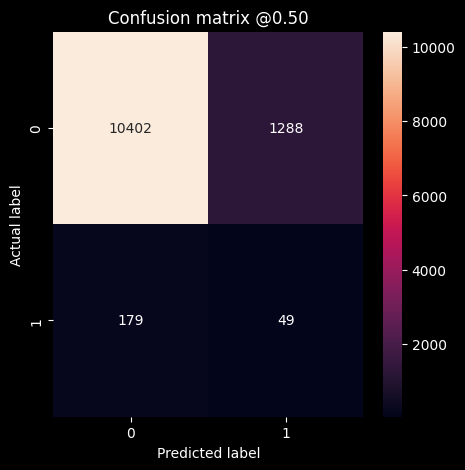

In [239]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

plot_cm(test_labels, test_predictions)
